In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io
import copy
def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)

    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_left = data[0,:,:] # x = 0
    b_right = data[-1,:,:] # x = 1
    b_upper = data[:,-1,:] # t = 1
    b_lower = data[:,0,:] # t = 0
    res = data.reshape(-1,2)

    return res, b_left, b_right, b_upper, b_lower


def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn_param=1
        for s in list(p.size()):
            nn_param = nn_param*s
        pp += nn_param
    return pp


def make_time_sequence(src, num_step=5, step=1e-4):
    dim = num_step
    src = np.repeat(np.expand_dims(src, axis=1), dim, axis=1)  # (N, L, 2)
    for i in range(num_step):
        src[:,i,-1] += step*i
    return src


def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
import copy

class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x) + self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)

class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs): 
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x

class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()
        
    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)
    
    
class FourierFeatures(nn.Module):
    def __init__(self, in_features, mapping_size=32, init_scale=0.1):
        super(FourierFeatures, self).__init__()
        # Instead of one scalar, use a vector of scales (one per frequency band)
        self.scale = nn.Parameter(torch.ones(mapping_size) * init_scale, requires_grad=True)
        self.B = nn.Parameter(torch.randn(in_features, mapping_size), requires_grad=True)

    def forward(self, x):
        x_proj = 2 * torch.pi * x @ (self.B * self.scale)
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class EnhancedEmbedding(nn.Module):
    def __init__(self, in_features, d_model, mapping_size=32, init_scale=0.1):
        super(EnhancedEmbedding, self).__init__()
        self.fourier = FourierFeatures(in_features, mapping_size, init_scale)
        # Adjust the linear layer to account for the increased dimensionality (2*mapping_size)
        self.linear = nn.Linear(2 * mapping_size, d_model)
        self.pos_emb = nn.Linear(in_features, d_model)

    def forward(self, x):
        fourier_features = self.fourier(x)
        token_emb = self.linear(fourier_features)
        pos_emb = self.pos_emb(x)
        return token_emb + pos_emb


class DecoderOnlyPINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        super(DecoderOnlyPINNsformer, self).__init__()

        self.linear_emb = nn.Linear(2, d_model)
        # Simple positional embedding as another linear layer.
        self.pos_emb = nn.Linear(2, d_model)

        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        )

    def forward(self, x, t):
        src = torch.cat((x, t), dim=-1)
        token_emb = self.linear_emb(src)
        pos_emb = self.pos_emb(src)
        src = token_emb + pos_emb

        d_output = self.decoder(src, src)  # decoder attends to input only
        output = self.linear_out(d_output)
        return output

class DecoderOnlyPINNsformerFourier(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads, init_scale=0.1, mapping_size=32):
        super(DecoderOnlyPINNsformerFourier, self).__init__()

        # Use the EnhancedEmbedding module which combines Fourier features and a learnable positional embedding.
        self.embedding = EnhancedEmbedding(in_features=2, d_model=d_model, mapping_size=mapping_size, init_scale=init_scale)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        )

    def forward(self, x, t):
        src = torch.cat((x, t), dim=-1)
        src = self.embedding(src)
        d_output = self.decoder(src, src)
        output = self.linear_out(d_output)
        return output

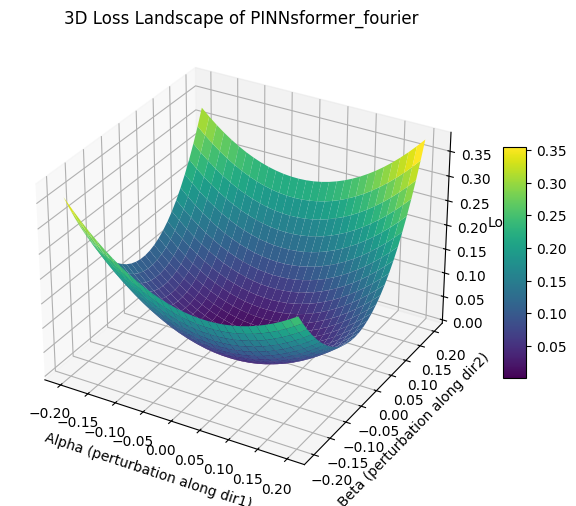

In [7]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import copy
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting


def visualize_loss_landscape_3d(model_path, n_points=30, range_scale=0.2):
    """
    Loads the saved PINNsformer_fourier model and visualizes a 3D surface plot of the loss landscape.
    
    The loss function evaluated is defined as:
      - PDE residual loss: mean((u_t + 50*u_x)^2)
      - Boundary condition loss: mean((pred_upper - pred_lower)^2)
      - Initial condition loss: mean((pred_left[:,0] - sin(x_left[:,0]))^2)
    
    Parameters:
      model_path (str): Path to the saved model weights (e.g., 'PINNsformer_fourier.pt').
      n_points (int): Number of grid points along each direction of the perturbation.
      range_scale (float): Maximum magnitude for the perturbations along each direction.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Recreate the model architecture (ensure the class DecoderOnlyPINNsformerFourier is defined)
    model = DecoderOnlyPINNsformerFourier(
        d_out=1, d_hidden=512, d_model=32, N=1, heads=2, init_scale=0.075
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Recreate training (interior and boundary) data
    res, b_left, b_right, b_upper, b_lower = get_data([0, 2*np.pi], [0, 1], 51, 51)
    res = make_time_sequence(res, num_step=5, step=1e-4)
    b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
    b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
    b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
    b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)
    
    res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
    b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
    b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
    b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
    b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)
    
    # Extract x and t components
    x_res, t_res = res[:, :, 0:1], res[:, :, 1:2]
    x_left, t_left = b_left[:, :, 0:1], b_left[:, :, 1:2]
    x_right, t_right = b_right[:, :, 0:1], b_right[:, :, 1:2]
    x_upper, t_upper = b_upper[:, :, 0:1], b_upper[:, :, 1:2]
    x_lower, t_lower = b_lower[:, :, 0:1], b_lower[:, :, 1:2]
    
    # Define the loss function
    def compute_loss():
        model.zero_grad()
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)
        u_x = torch.autograd.grad(
            pred_res, x_res, grad_outputs=torch.ones_like(pred_res), 
            retain_graph=True, create_graph=True
        )[0]
        u_t = torch.autograd.grad(
            pred_res, t_res, grad_outputs=torch.ones_like(pred_res), 
            retain_graph=True, create_graph=True
        )[0]
        loss_res = torch.mean((u_t + 50 * u_x) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:, 0] - torch.sin(x_left[:, 0])) ** 2)
        return loss_res
    
    # Helper function to vectorize the model parameters
    def get_param_vector():
        return torch.cat([p.detach().flatten() for p in model.parameters()])
    
    orig_params = get_param_vector()
    param_dim = orig_params.shape[0]
    
    # Create two random normalized direction vectors in parameter space.
    dir1 = torch.randn(param_dim).to(device)
    dir1 = dir1 / torch.norm(dir1)
    dir2 = torch.randn(param_dim).to(device)
    dir2 = dir2 / torch.norm(dir2)
    
    # Save the original model state to restore later.
    orig_state = copy.deepcopy(model.state_dict())
    
    # Generate a grid over the two perturbation dimensions.
    a_vals = np.linspace(-range_scale, range_scale, n_points)
    b_vals = np.linspace(-range_scale, range_scale, n_points)
    loss_grid = np.zeros((n_points, n_points))
    
    # Evaluate loss over the grid of perturbations.
    for i, a in enumerate(a_vals):
        for j, b in enumerate(b_vals):
            new_param_vector = orig_params + a * dir1 + b * dir2
            pointer = 0
            for p in model.parameters():
                numel = p.numel()
                new_vals = new_param_vector[pointer:pointer+numel].view(p.size())
                p.data.copy_(new_vals)
                pointer += numel
            loss_grid[j, i] = compute_loss().item()
    
    # Restore the original model weights
    model.load_state_dict(orig_state)
    
    # Create a 3D surface plot of the loss landscape.
    A, B = np.meshgrid(a_vals, b_vals)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(A, B, loss_grid, cmap='viridis', edgecolor='none')
    fig.colorbar(surf, shrink=0.5, aspect=10)
    ax.set_xlabel('Alpha (perturbation along dir1)')
    ax.set_ylabel('Beta (perturbation along dir2)')
    ax.set_zlabel('Loss')
    ax.set_title('3D Loss Landscape of PINNsformer_fourier')
    plt.show()

# Example usage:
visualize_loss_landscape_3d("PINNsformer_fourier.pt", n_points=30, range_scale=0.2)
